# Вебинар 6. Консультация по курсовому проекту.

### Задание для курсового проекта

Метрика:
rmse -корень среднеквадратичного отклонения

Сдача проекта:
1. Прислать в раздел Задания Урока 10 ("Вебинар. Консультация по итоговому проекту")
ссылку на программу в github (программа должна содержаться в файле Jupyter Notebook 
с расширением ipynb). (Pull request не нужен, только ссылка ведущая на сам скрипт).
2. Приложить файл с названием по образцу SShirkin_predictions.csv
с предсказанными ценами для квартир из test.csv (файл должен содержать два поля: Id, Price).
В файле с предсказаниями должна быть 5001 строка (шапка + 5000 предсказаний).

Сроки и условия сдачи:
Для успешной сдачи должны быть все предсказания (для 5000 квартир) и R2 должен быть больше 0.6.
При сдаче до дедлайна результат проекта может попасть в топ лучших результатов.
Повторная сдача и проверка результатов возможны только при условии предыдущей неуспешной сдачи.
Успешный проект нельзя пересдать в целях повышения результата.
Проекты, сданные после дедлайна или сданные повторно, не попадают в топ лучших результатов, но можно узнать результат.
В качестве итогового результата берется первый успешный результат, последующие успешные результаты не учитываются.

Примечание:
Все файлы csv должны содержать названия полей (header - то есть "шапку"),
разделитель - запятая. В файлах не должны содержаться индексы из датафрейма.

Рекомендации для файла с кодом (ipynb):
1. Файл должен содержать заголовки и комментарии
2. Повторяющиеся операции лучше оформлять в виде функций
3. Не делать вывод большого количества строк таблиц (5-10 достаточно)
4. По возможности добавлять графики, описывающие данные (около 3-5)
5. Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
6. Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
7. Весь проект должен быть в одном скрипте (файл ipynb).
8. При использовании статистик (среднее, медиана и т.д.) в качестве признаков,
лучше считать их на трейне, и потом на валидационных и тестовых данных не считать 
статистики заново, а брать их с трейна. Если хватает знаний, можно использовать кросс-валидацию,
но для сдачи этого проекта достаточно разбить данные из train.csv на train и valid.
9. Проект должен полностью отрабатывать за разумное время (не больше 10 минут),
поэтому в финальный вариант лучше не включать GridSearch с перебором 
большого количества сочетаний параметров.
10. Допускается применение библиотек Python и моделей машинного обучения,
которые были в курсе Python для Data Science. Градиентный бустинг изучается
в последующих курсах, поэтому в этом проекте его применять не следует.
Самая сложная из допустимых моделей - RandomForestRegressor из sklearn.


https://www.kaggle.com/competitions/real-estate-price-prediction-moscow/data


**Построение модели регресси**
1. Обзор обучающего датасета
2. Обработка выбросов
3. Обработка пропусков
4. Анализ данных
5. Отбор признаков
6. Подбор моделей, получение бейзлана
7. Проверка качества, борьба с переобучением
8. Интерпретация результатов

**Прогнозирование на тестовом датасете**
1. Выполнить для тестового датасета те же этапы обработки и постронияния признаков
2. Спрогнозировать целевую переменную, используя модель, построенную на обучающем датасете
3. Прогнозы должны быть для всех примеров из тестового датасета (для всех строк)
4. Соблюдать исходный порядок примеров из тестового датасета

### ToDo

1. Разбить площадь на категории и посчитать цену
2. Посчитать цену на кв. метр
3. Валидационная выборка
4. Перенос признаков на тест

**Подключение библиотек и скриптов**

In [1]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.decomposition import PCA

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
matplotlib.rcParams.update({'font.size': 14})

In [5]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

**Пути к директориям и файлам**

In [6]:
TRAIN_DATASET_PATH = 'train.csv'
TEST_DATASET_PATH = 'test.csv'

### Загрузка данных

**Описание датасета**

* **Id** - идентификационный номер квартиры
* **DistrictId** - идентификационный номер района
* **Rooms** - количество комнат
* **Square** - площадь
* **LifeSquare** - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - количество этажей в доме
* **HouseYear** - год постройки дома
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
* **Social_1, Social_2, Social_3** - социальные показатели местности
* **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
* **Price** - цена квартиры

In [7]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
train_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
9995,1260,61,2.0,49.090728,33.272626,6.0,3,12.0,1981,0.300323,B,B,52,10311,6,NaN,1,9,B,119367.455796
9996,16265,27,2.0,64.307684,37.038420,9.0,13,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,199715.148807
9997,2795,178,1.0,29.648057,16.555363,5.0,3,5.0,1958,0.460556,B,B,20,4386,14,NaN,1,5,B,165953.912580
9998,14561,21,1.0,32.330292,22.326870,5.0,3,9.0,1969,0.194489,B,B,47,8004,3,125.0,3,5,B,171842.411855
9999,7202,94,1.0,35.815476,22.301367,6.0,9,9.0,1975,0.127376,B,B,43,8429,3,NaN,3,9,B,177685.627486


In [8]:
test_df = pd.read_csv(TEST_DATASET_PATH)
test_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
4995,10379,29,2.0,43.177521,30.339945,5.0,6,5.0,1962,0.069660,B,B,31,6119,4,NaN,1,2,B
4996,16138,38,3.0,93.698122,94.521465,10.0,21,27.0,2018,0.060753,B,B,15,2787,2,520.0,0,7,B
4997,3912,101,1.0,33.656723,19.003259,5.0,2,5.0,1966,0.038693,B,B,28,6533,1,1015.0,2,5,B
4998,5722,10,1.0,38.635155,20.976257,9.0,8,14.0,1970,0.089040,B,B,33,7976,5,NaN,0,11,B
4999,11004,21,2.0,67.122742,33.944344,13.0,9,17.0,2009,0.194489,B,B,47,8004,3,125.0,3,5,B


In [9]:
train_df.shape[1]-1 == test_df.shape[1]

True

## приведение типов

In [10]:
#Пропуски в фичах LifeSquare and Healthcare_1
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

In [11]:
train_df['DistrictId'] = train_df['DistrictId'].astype(str)

In [12]:
train_df = train_df.drop('Id', axis =1 )

In [13]:
test_df = test_df.drop('Id', axis =1)

In [14]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [15]:
reduce_mem_usage(train_df)
train_df.head()

Memory usage of dataframe is 1.45 MB
Memory usage after optimization is: 0.48 MB
Decreased by 67.1%


,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,27,3.0,115.027313,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.875000
1,22,1.0,39.832523,23.169222,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.546875
2,1,3.0,78.342216,47.671970,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.718750
3,1,1.0,40.409908,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.000000
4,94,2.0,64.285065,38.562515,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.093750


In [16]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   DistrictId     10000 non-null  category
 1   Rooms          10000 non-null  float32 
 2   Square         10000 non-null  float32 
 3   LifeSquare     7887 non-null   float32 
 4   KitchenSquare  10000 non-null  float32 
 5   Floor          10000 non-null  int8    
 6   HouseFloor     10000 non-null  float32 
 7   HouseYear      10000 non-null  int32   
 8   Ecology_1      10000 non-null  float32 
 9   Ecology_2      10000 non-null  category
 10  Ecology_3      10000 non-null  category
 11  Social_1       10000 non-null  int8    
 12  Social_2       10000 non-null  int16   
 13  Social_3       10000 non-null  int16   
 14  Healthcare_1   5202 non-null   float32 
 15  Helthcare_2    10000 non-null  int8    
 16  Shops_1        10000 non-null  int8    
 17  Shops_2        10000 non-null  c

## Обзор данных 

In [17]:
def stat_plot(data, feature, h=0.00000652, b=30):
    plt.figure(figsize=(16, 8))
    data[feature].hist(bins=b, density=True)
    plt.ylabel('Density')
    plt.xlabel(feature)
    plt.title('{} distribution'.format(feature))
    feature_mean = round(data[feature].mean(), 2)
    feature_median = data[feature].median()
    feature_mode = data[feature].mode()[0]
    y = np.linspace(0, h, 10)
    plt.plot([feature_mean] * 10, y, label='mean',  linewidth=4)
    plt.plot([feature_median] * 10, y, label='median',  linewidth=4)
    plt.plot([feature_mode] * 10, y, label='mode', linewidth=4)
    plt.legend()
    plt.show()
    print(feature, 'mean:', feature_mean)
    print(feature, 'median:', feature_median)
    print(feature, 'mode:', feature_mode)
    
    

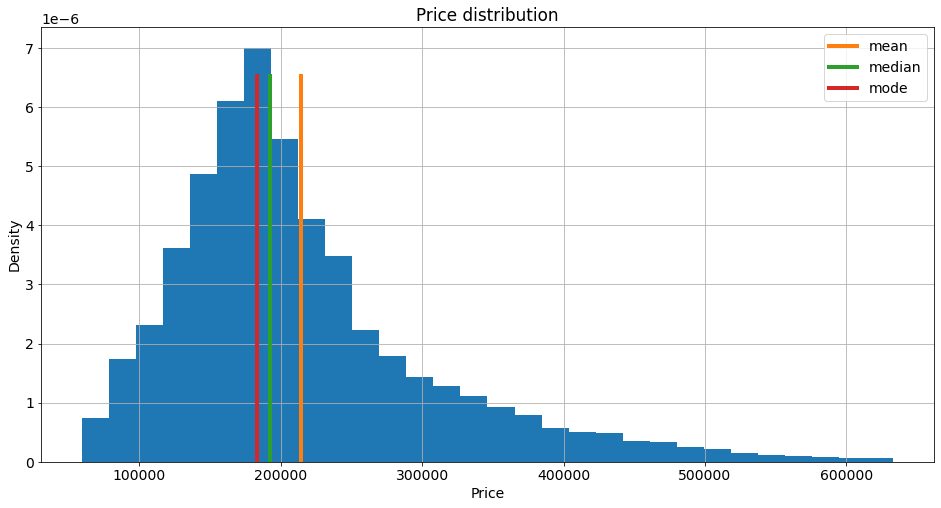

Price mean: 214138.94
Price median: 192269.65625
Price mode: 182938.08


In [18]:
stat_plot(train_df, 'Price')

#### колич переменные 

In [19]:
# по этим данным понятно что есть выброс данных на разных фичах
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.0000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.890500,56.315720,37.199665,6.273300,8.526700,12.6094,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904419,1.319500,4.231300,214138.937500
std,0.839522,21.058716,86.241219,28.560839,5.241148,6.7762,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.519470,1.493601,4.806341,92872.273438
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.0000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.777344
25%,1.000000,41.774879,22.769833,1.000000,4.000000,9.0000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.628906
50%,2.000000,52.513309,32.781261,6.000000,7.000000,13.0000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.648438
75%,2.000000,65.900627,45.128803,9.000000,12.000000,17.0000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.460938
max,19.000000,641.065186,7480.592285,2014.000000,42.000000,117.0000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.437500


#### кач перменные 

In [20]:
train_df.select_dtypes(include='category').columns.tolist()

['DistrictId', 'Ecology_2', 'Ecology_3', 'Shops_2']

In [21]:
train_df['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [22]:
train_df['Ecology_3'].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

In [23]:
train_df['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

In [24]:
train_df['DistrictId'].value_counts()

27     851
1      652
23     565
6      511
9      294
      ... 
207      1
117      1
209      1
174      1
199      1
Name: DistrictId, Length: 205, dtype: int64

## обработка выбросов 

### Rooms

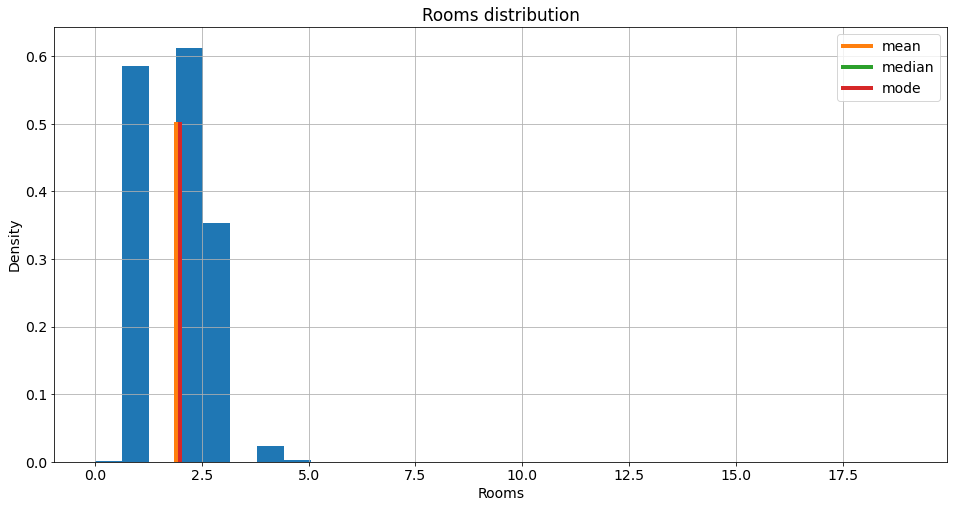

Rooms mean: 1.89
Rooms median: 2.0
Rooms mode: 2.0


In [25]:
stat_plot(train_df, 'Rooms', h=0.5, b=30)

In [26]:
train_df['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

In [27]:
#обработка данных
class Preproc:
    def fit_emiss(self, data):
        self.emiss_median_rooms = data['Rooms'].median()
        #обработка Square, Life Square, KitchenSquare
        self.emiss_median_Square = data['Square'].median()
        self.emiss_quantiledown_square = data['Square'].quantile(.025)
        self.emiss_quantileup_square = data['Square'].quantile(.975)
        self.emiss_median_LifeSquare = data['LifeSquare'].median()
        self.emiss_quantiledown_Lifesquare = data['LifeSquare'].quantile(.025)
        self.emiss_quantileup_Lifesquare = data['LifeSquare'].quantile(.975)
        self.emiss_median_KitchenSquare = data['KitchenSquare'].median()
        self.emiss_quantiledown_KitchenSquare = data['KitchenSquare'].quantile(.025)
        self.emiss_quantileup_KitchenSquare = data['KitchenSquare'].quantile(.975)
        #обработка пропуска в Healthcare_1
        self.emiss_median_Healthcare_1 = data['Healthcare_1'].median()
        #для размышления
        #self.Square_out = data.loc[data['LifeSquare'] > data['Square']].index
        #self.min_square_out = round(min(data.loc[self.Square_out, 'LifeSquare']))
        #
        #HouseYear
        self.emiss_median_HouseYear = data['HouseYear'].median()
        
        
        #### Для новых фичей 
        
        

    def transf_emiss(self, data):
        #обработка выбросов Rooms
        data.loc[(data['Rooms'] >= 6) | (data['Rooms'] == 0), 'Rooms'] = self.emiss_median_rooms
        #обработка выбросов Square
        data.loc[
        ((data['Square'] > self.emiss_quantileup_square) |
        (data['Square'] < self.emiss_quantiledown_square)), 'Square'] =   self.emiss_median_Square
        #обработка выбросов LifeSquare
        data.loc[
        ((data['LifeSquare'] > self.emiss_quantileup_Lifesquare) |
        (data['LifeSquare'] < self.emiss_quantiledown_Lifesquare)), 'LifeSquare'] = self.emiss_median_LifeSquare
        #обработка выбросов KitchenSquare и заполнение его пропуска
        data.loc[
        ((data['KitchenSquare'] > self.emiss_quantileup_KitchenSquare) |
        (data['KitchenSquare'] < self.emiss_quantiledown_KitchenSquare)), 'KitchenSquare'] = self.emiss_median_KitchenSquare
        data.loc[data['KitchenSquare'] < 3, 'KitchenSquare'] = 3 # площади которые меньше трех невозмодные данные
        data.loc[data['LifeSquare'].isna(), 'LifeSquare'] = self.emiss_median_LifeSquare
        # Обработка данные этажей в которых этаж квартире больше чем количество этажей дома
        data.loc[(data.loc[data['Floor'] > data['HouseFloor']].index), 'Floor'] = data.loc[(data.loc[data['Floor'] > data['HouseFloor']].index), 'HouseFloor'].apply(lambda x: random.randint(0, x))
        # Обработка пропуска для фича Healthcare_1 
        data.loc[data['Healthcare_1'].isnull(), 'Healthcare_1'] = self.emiss_median_Healthcare_1
        # Обработка нереальных данных для площадей
        data['Square'], data['LifeSquare'] = np.where(data['Square'] < data['LifeSquare'],(data['LifeSquare'], data['Square']), (data['Square'],data['LifeSquare']))
        # в некоторых площадей, площадь кухни больше чем общая площадь, поэтому между этими просто поменял местами,
        #data.loc[self.Square_out, 'LifeSquare'] = data.loc[self.Square_out, 'Square'].apply(lambda x: random.randint(self.min_square_out, round(x)))
        
        
        # #HouseYear Заменить данные которые выше чем текущий год на медиану. 
        data.loc[data['HouseYear'] > 2022, 'HouseYear'] = self.emiss_median_HouseYear
        
        
        # Изменения категориальных признаков в бинарные
        
        data.replace({'Ecology_2': {'A': 0, 'B': 1}}, inplace=True)
        data.replace({'Ecology_3': {'A': 0, 'B': 1}}, inplace=True)
        data.replace({'Shops_2': {'A': 0, 'B': 1}}, inplace=True)
        
            

In [28]:
prep = Preproc()
prep.fit_emiss(train_df)
prep.transf_emiss(train_df)
prep.transf_emiss(test_df)

In [29]:
train_df.head(2)

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,27,3.0,52.513309,32.781261,10.0,4,10.0,2014,0.075424,1,1,11,3097,0,900.0,0,0,1,305018.875000
1,22,1.0,39.832523,23.169222,8.0,7,8.0,1966,0.118537,1,1,30,6207,1,1183.0,1,0,1,177734.546875


In [30]:
test_df.head(2)

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,44,1.0,36.847630,19.094182,5.0,5,9.0,1970,0.036122,1,1,24,4378,0,1036.0,1,1,1
1,62,1.0,42.568133,42.493907,10.0,7,17.0,2017,0.072158,1,1,2,629,1,900.0,0,0,0


In [31]:
train_df['Rooms'].value_counts()

2.0    3892
1.0    3705
3.0    2235
4.0     150
5.0      18
Name: Rooms, dtype: int64

### Square	LifeSquare	KitchenSquare

In [32]:
# Во первых логически не может быть площадь кухни быть больше общая площадь или жилая площадь, 
# поэтому эти данные можно заменить с медианой или средней

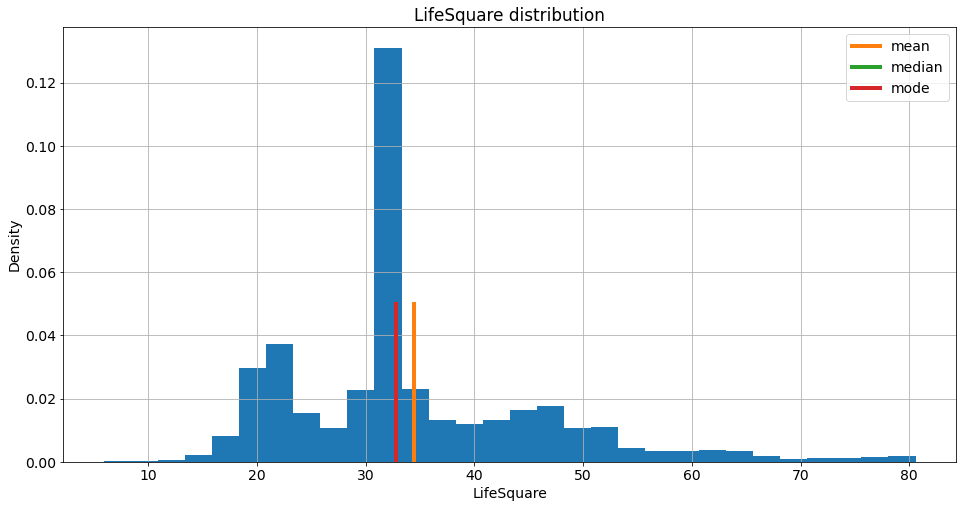

LifeSquare mean: 34.49
LifeSquare median: 32.7812614440918
LifeSquare mode: 32.78126


In [33]:
stat_plot(train_df, 'LifeSquare', h= 0.05, b= 30)

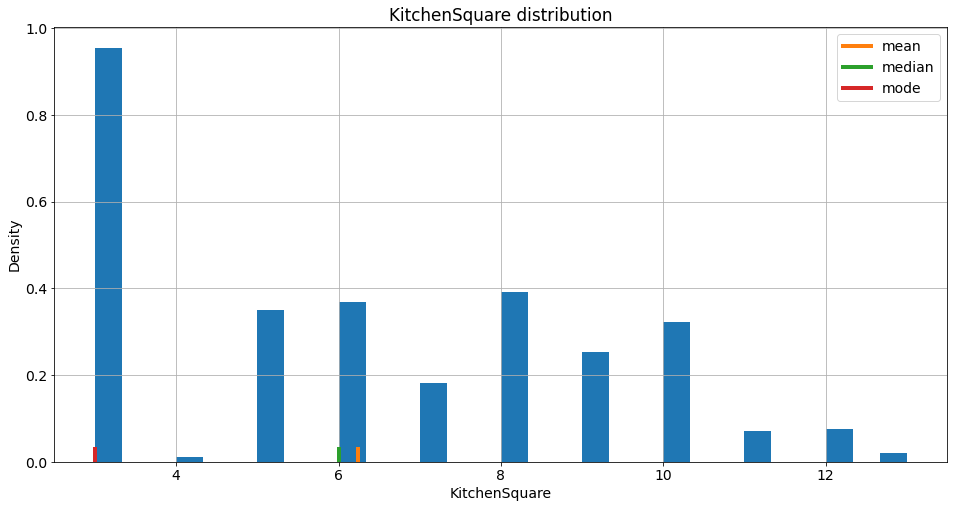

KitchenSquare mean: 6.24
KitchenSquare median: 6.0
KitchenSquare mode: 3.0


In [34]:
stat_plot(train_df, 'KitchenSquare', h= 0.03, b= 30)

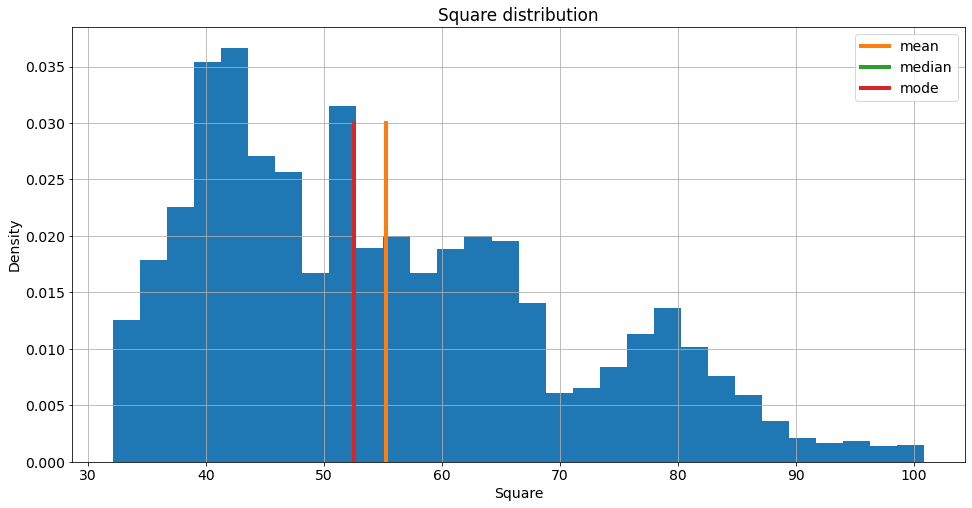

Square mean: 55.29
Square median: 52.513309478759766
Square mode: 52.51331


In [35]:
stat_plot(train_df, 'Square', h= 0.03, b= 30)

In [36]:
# проверка есть ли нереальные данные в площадях
sum(train_df['KitchenSquare'] > train_df['Square'])

0

In [37]:
sum(train_df['LifeSquare'] > train_df['Square'])

0

### Floor	HouseFloor	

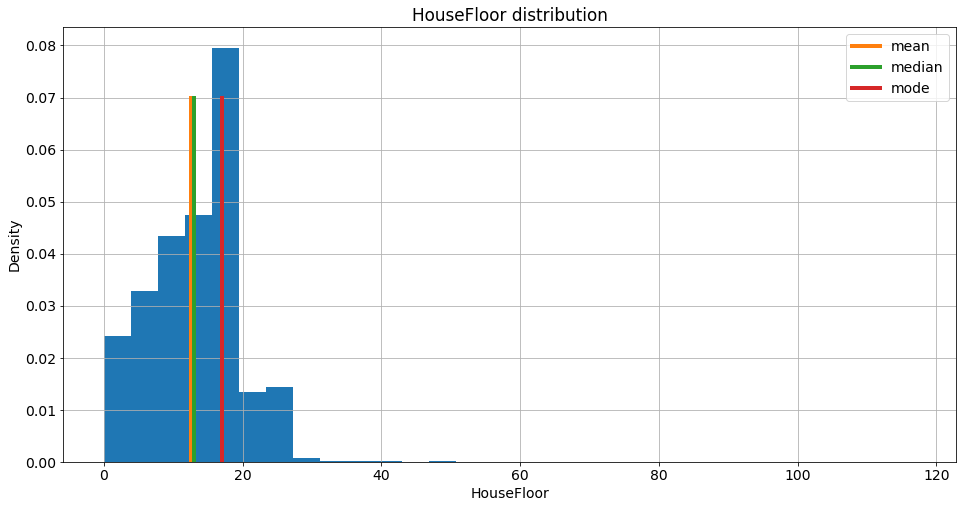

HouseFloor mean: 12.61
HouseFloor median: 13.0
HouseFloor mode: 17.0


In [38]:
stat_plot(train_df, 'HouseFloor', h =0.07)

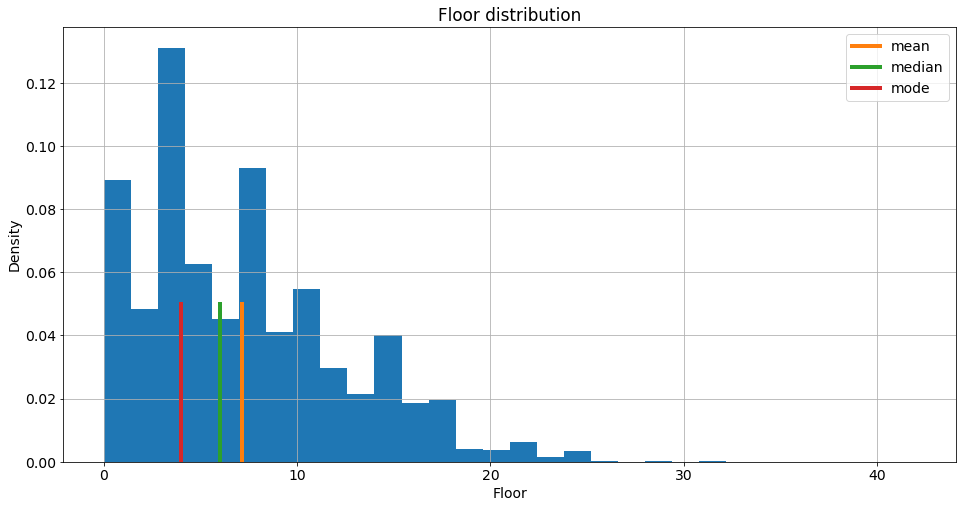

Floor mean: 7.13
Floor median: 6.0
Floor mode: 4


In [39]:
stat_plot(train_df, 'Floor', h=0.05)

In [40]:
train_df['HouseFloor'].sort_values().unique()

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        36.,  37.,  38.,  39.,  40.,  44.,  45.,  47.,  48.,  99., 117.],
      dtype=float32)

In [41]:
train_df['Floor'].sort_values().unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 31, 32, 33, 37, 42],
      dtype=int64)

In [42]:
# проверка есть ли нереальные данные в количество этажах
sum(train_df['Floor'] > train_df['HouseFloor'])

0

In [43]:
sum(train_df['KitchenSquare'] > train_df['LifeSquare'])

1

## Обработка пропусков

In [44]:
len(train_df) - train_df.count()

DistrictId       0
Rooms            0
Square           0
LifeSquare       0
KitchenSquare    0
Floor            0
HouseFloor       0
HouseYear        0
Ecology_1        0
Ecology_2        0
Ecology_3        0
Social_1         0
Social_2         0
Social_3         0
Healthcare_1     0
Helthcare_2      0
Shops_1          0
Shops_2          0
Price            0
dtype: int64

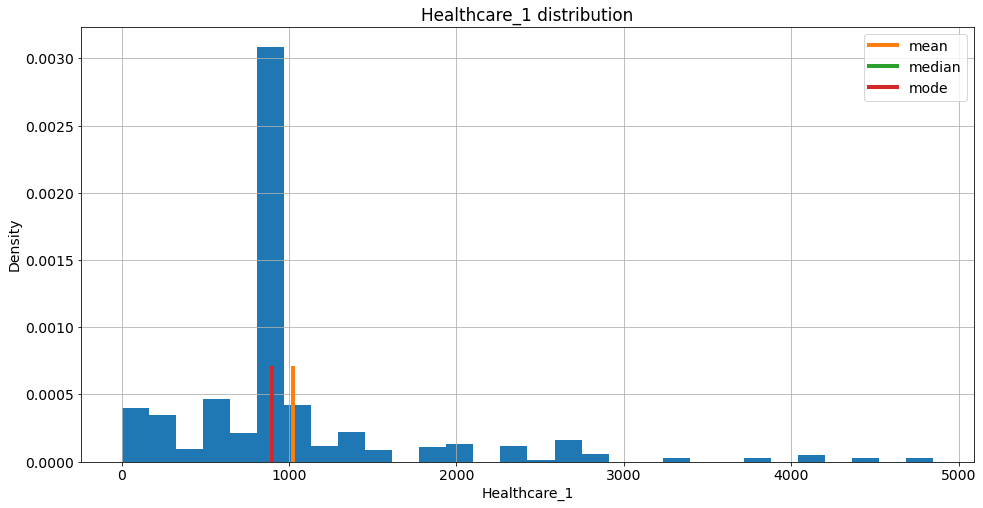

Healthcare_1 mean: 1026.36
Healthcare_1 median: 900.0
Healthcare_1 mode: 900.0


In [45]:
stat_plot(train_df, 'Healthcare_1', h=0.0007)

In [46]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.0000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,1.888400,55.293232,34.485882,6.238200,7.131600,12.6094,1984.863800,0.118858,24.687000,5352.157400,8.039200,1026.358887,1.319500,4.231300,214138.937500
std,0.811071,15.252085,11.636042,2.794661,5.225037,6.7762,18.409979,0.119025,17.532614,4006.799803,23.831875,746.644226,1.493601,4.806341,92872.273438
min,1.000000,32.105270,5.927865,3.000000,0.000000,0.0000,1910.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.777344
25%,1.000000,42.466958,27.626607,3.000000,3.000000,9.0000,1974.000000,0.017647,6.000000,1564.000000,0.000000,830.000000,0.000000,1.000000,153872.628906
50%,2.000000,52.513309,32.781261,6.000000,6.000000,13.0000,1977.000000,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.648438
75%,2.000000,64.958002,39.542203,8.000000,10.000000,17.0000,2001.000000,0.195781,36.000000,7227.000000,5.000000,990.000000,2.000000,6.000000,249135.460938
max,5.000000,100.904266,80.577263,13.000000,42.000000,117.0000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.437500


### Ecology_1

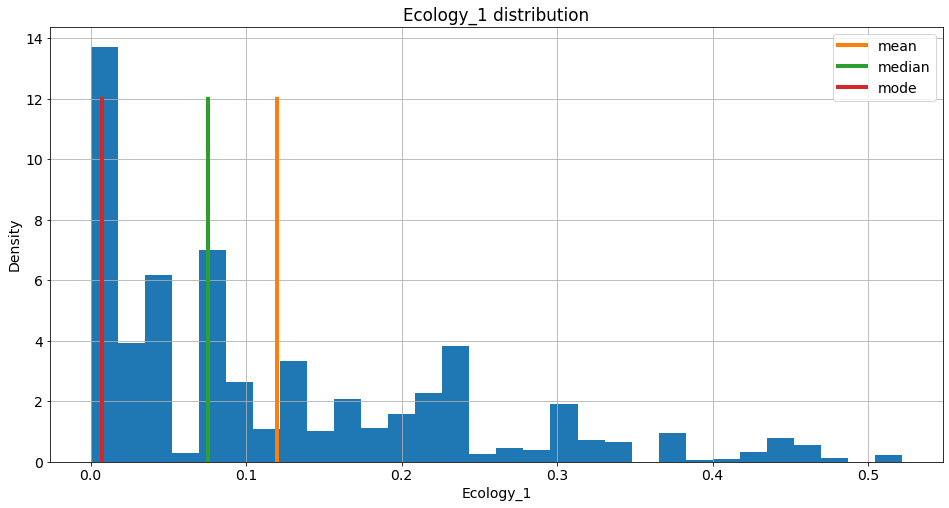

Ecology_1 mean: 0.12
Ecology_1 median: 0.07542368024587631
Ecology_1 mode: 0.007122317


In [47]:
stat_plot(train_df, 'Ecology_1', h=12)

### Social_1 and Social_2 and Social_3

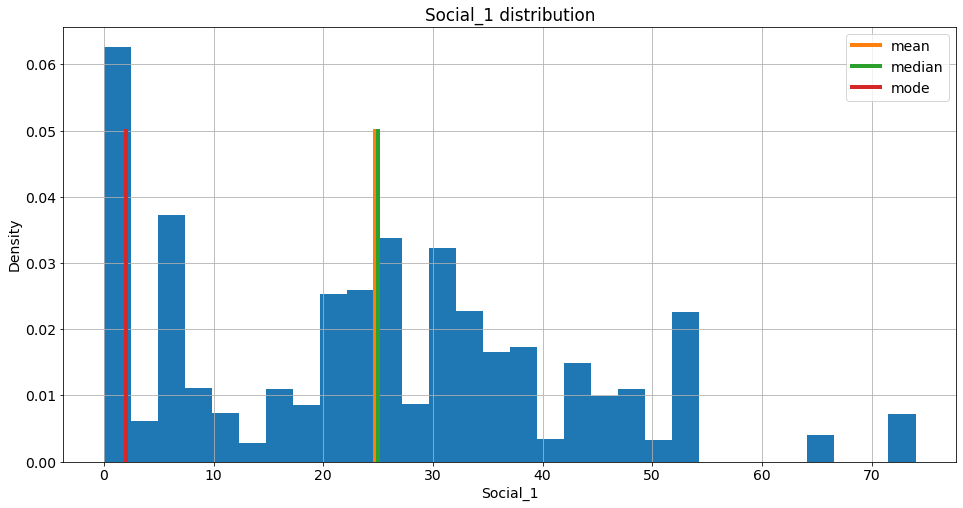

Social_1 mean: 24.69
Social_1 median: 25.0
Social_1 mode: 2


In [48]:
stat_plot(train_df, 'Social_1', h=0.05)

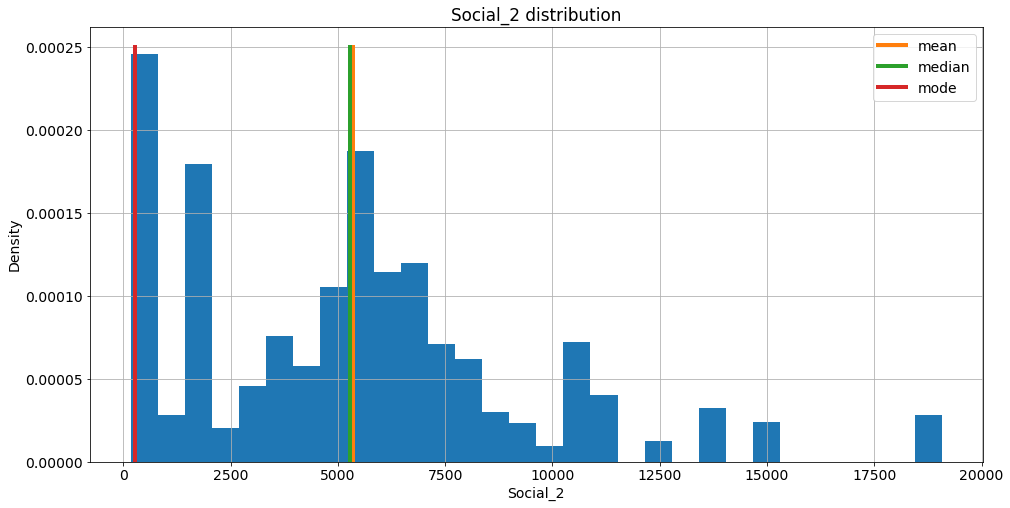

Social_2 mean: 5352.16
Social_2 median: 5285.0
Social_2 mode: 264


In [49]:
stat_plot(train_df, 'Social_2', h=0.00025)

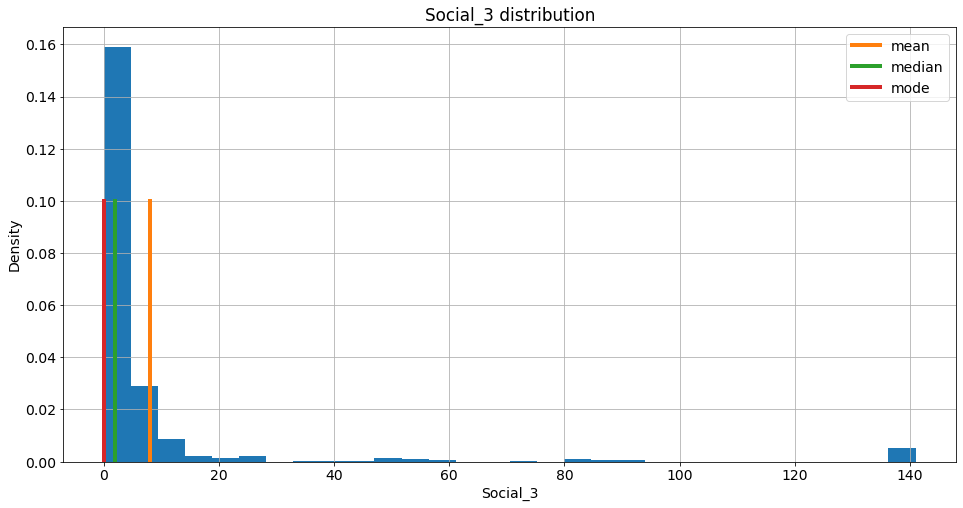

Social_3 mean: 8.04
Social_3 median: 2.0
Social_3 mode: 0


In [50]:
stat_plot(train_df, 'Social_3', h=0.1)

### Heatlhcare_1 and Healthcare_2

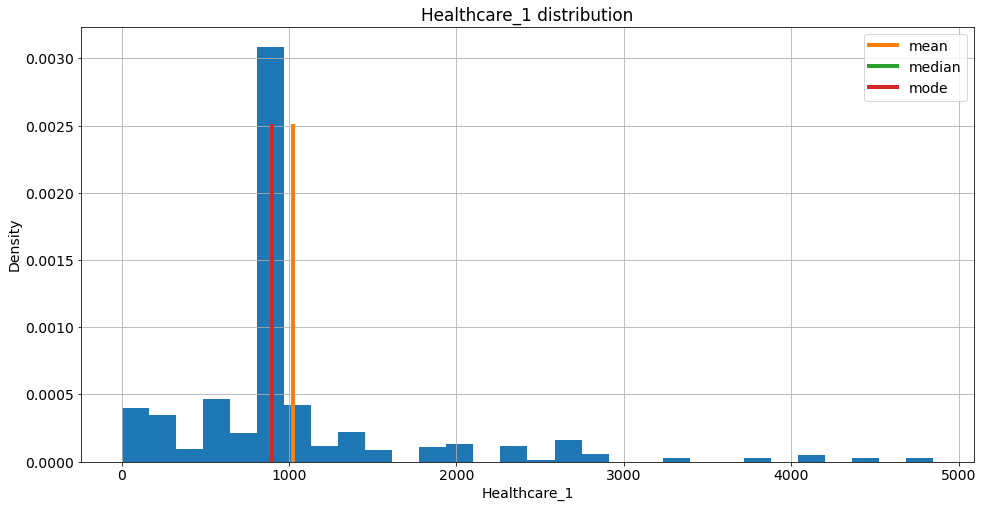

Healthcare_1 mean: 1026.36
Healthcare_1 median: 900.0
Healthcare_1 mode: 900.0


In [51]:
stat_plot(train_df, 'Healthcare_1', h =0.0025)

In [52]:
train_df['Helthcare_2'].value_counts()

0    4214
1    2183
3    1670
2    1158
5     388
4     288
6      99
Name: Helthcare_2, dtype: int64

### Shop_1

In [53]:
train_df['Shops_1'].value_counts()

0     2316
1     1325
5     1324
2      964
4      841
3      711
6      487
11     401
9      316
7      294
8      253
23     245
10     215
15     176
16      83
19      49
Name: Shops_1, dtype: int64

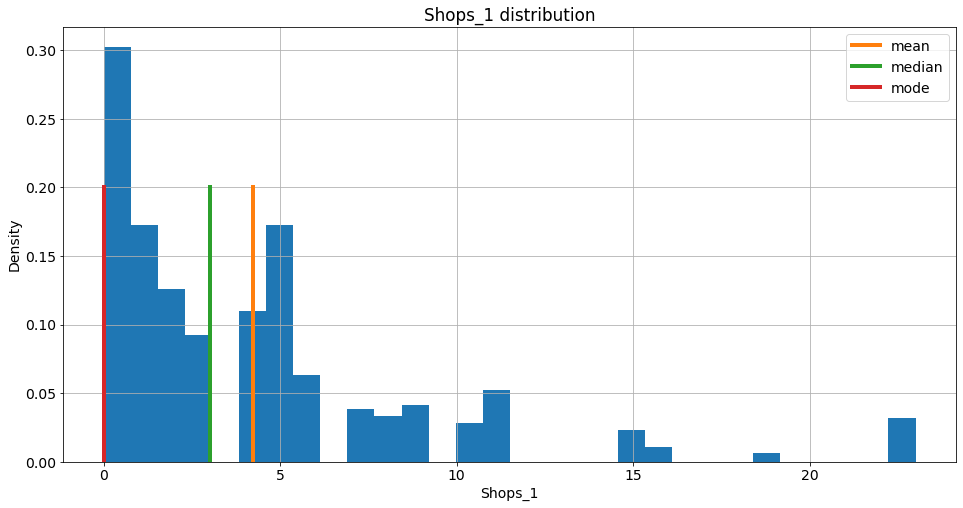

Shops_1 mean: 4.23
Shops_1 median: 3.0
Shops_1 mode: 0


In [54]:
stat_plot(train_df, 'Shops_1', h =0.2)

### HouseYear

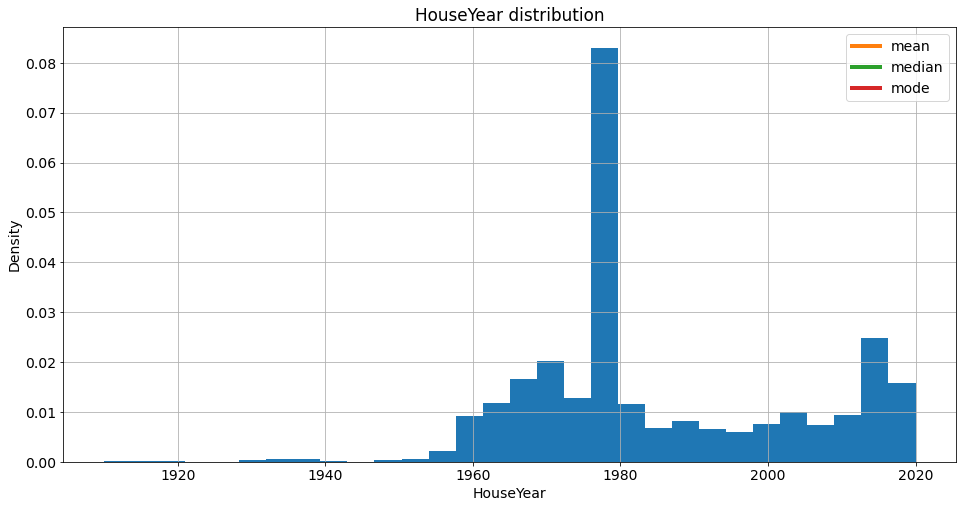

HouseYear mean: 1984.86
HouseYear median: 1977.0
HouseYear mode: 1977


In [55]:
stat_plot(train_df, 'HouseYear', h = 0.000001)

In [56]:
#проверка нет ли ошибка в данных 
sum(train_df['HouseYear'] > 2022)

0

### Категориальные признаки

In [57]:
train_df['Shops_2'].value_counts()

1    9175
0     825
Name: Shops_2, dtype: int64

In [58]:
train_df['Ecology_2'].value_counts()

1    9903
0      97
Name: Ecology_2, dtype: int64

In [59]:
train_df['Ecology_3'].value_counts()

1    9725
0     275
Name: Ecology_3, dtype: int64

### Корреляция между признаками

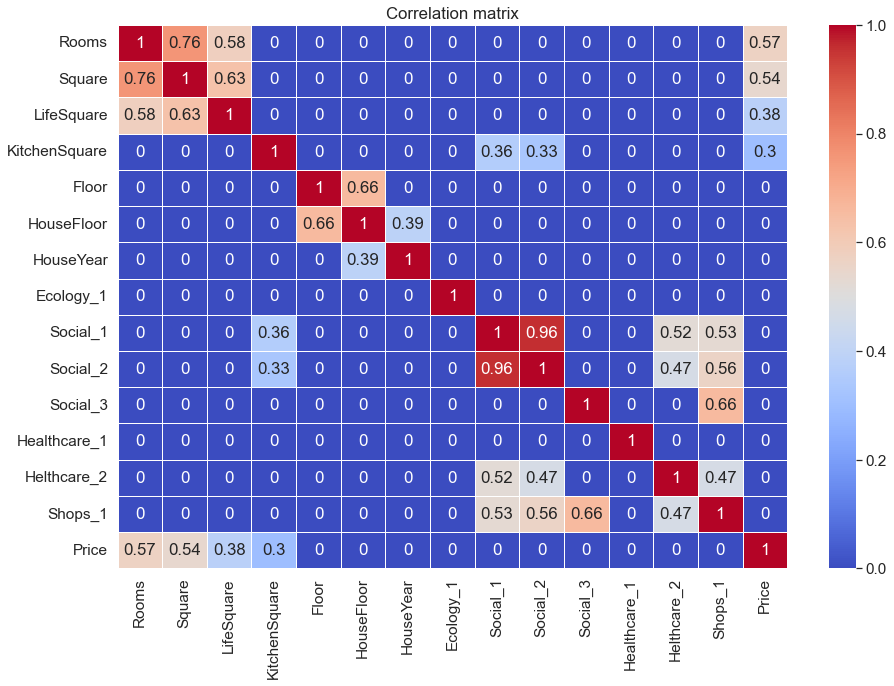

In [60]:
plt.figure(figsize = (15,10))

sns.set(font_scale=1.4)

corr_matrix = train_df.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=0.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

## новые признаки 

In [61]:
train_df.head(2)

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,27,3.0,52.513309,32.781261,10.0,4,10.0,2014,0.075424,1,1,11,3097,0,900.0,0,0,1,305018.875000
1,22,1.0,39.832523,23.169222,8.0,7,8.0,1966,0.118537,1,1,30,6207,1,1183.0,1,0,1,177734.546875


In [62]:
# Добавил две новые признаки, и удалил 5 ненужных признаков которых посчитал не нужными
class FeatureGenerator:
    def __init__(self):
        self.districts_median_year = None
        self.districts_density = None
        self.district_price_per_square = None
        
    def create_new_feat(self, data):

        # Median price for square meter in each district
        #self.district_price_per_square.to_dict()
        #data['DistrictPrice'] = data['DistrictId'].map(self.district_price_per_square)
        
       # self.median_district_price_per_square = data['DistrictPrice'].median()
       # data['DistrictPrice'].fillna(self.median_district_price_per_square, inplace=True)


        # Floor category
        floor_bins = [0, 4, 7, 12, data['Floor'].max()]
        data['Floor_cat'] = pd.cut(data['Floor'], bins=floor_bins, labels=False)
        data['Floor_cat'].fillna(-1, inplace=True) 

        
        # Scale and merge Social
        scaler = RobustScaler()
        pca = PCA(n_components=1, random_state=42)
        social_scaled = pd.DataFrame(scaler.fit_transform(data[['Social_1', 'Social_2', 'Social_3']]))
        data['Social'] = pca.fit_transform(social_scaled)
        
        
        data.drop(['Ecology_2', 'Ecology_3', 'Shops_2', 'Helthcare_2', 'Floor',], axis=1, inplace=True)
        
        return data
    

In [63]:
features_gen = FeatureGenerator()
train_df = features_gen.create_new_feat(train_df)
test_df = features_gen.create_new_feat(test_df)

In [64]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   DistrictId     10000 non-null  category
 1   Rooms          10000 non-null  float32 
 2   Square         10000 non-null  float32 
 3   LifeSquare     10000 non-null  float32 
 4   KitchenSquare  10000 non-null  float32 
 5   HouseFloor     10000 non-null  float32 
 6   HouseYear      10000 non-null  int32   
 7   Ecology_1      10000 non-null  float32 
 8   Social_1       10000 non-null  int8    
 9   Social_2       10000 non-null  int16   
 10  Social_3       10000 non-null  int16   
 11  Healthcare_1   10000 non-null  float32 
 12  Shops_1        10000 non-null  int8    
 13  Price          10000 non-null  float32 
 14  Floor_cat      10000 non-null  float64 
 15  Social         10000 non-null  float64 
dtypes: category(1), float32(8), float64(2), int16(2), int32(1), int8(2)
memory us

In [65]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   DistrictId     5000 non-null   int64  
 1   Rooms          5000 non-null   float64
 2   Square         5000 non-null   float64
 3   LifeSquare     5000 non-null   float64
 4   KitchenSquare  5000 non-null   float64
 5   HouseFloor     5000 non-null   float64
 6   HouseYear      5000 non-null   int64  
 7   Ecology_1      5000 non-null   float64
 8   Social_1       5000 non-null   int64  
 9   Social_2       5000 non-null   int64  
 10  Social_3       5000 non-null   int64  
 11  Healthcare_1   5000 non-null   float64
 12  Shops_1        5000 non-null   int64  
 13  Floor_cat      5000 non-null   float64
 14  Social         5000 non-null   float64
dtypes: float64(9), int64(6)
memory usage: 586.1 KB


## train и test

In [66]:
train_df.columns.to_list()

['DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Shops_1',
 'Price',
 'Floor_cat',
 'Social']

In [67]:
feat = ['DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1', 'Shops_1', 'Floor_cat', 'Social']

In [68]:
x = train_df[feat]
y = train_df['Price']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

In [132]:
forest = RandomForestRegressor(max_depth=35, # глубина дерева   # минимальное кол-во наблюдений в листе дерева
                                 random_state=42,
                                 min_samples_leaf = 1,
                                 n_estimators=200  # кол-во деревьев
                                 )

forest.fit(x_train, y_train)
y_train_preds = forest.predict(x_train)

##### отложенная выборка

Train R2:	0.96
Test R2:	0.734


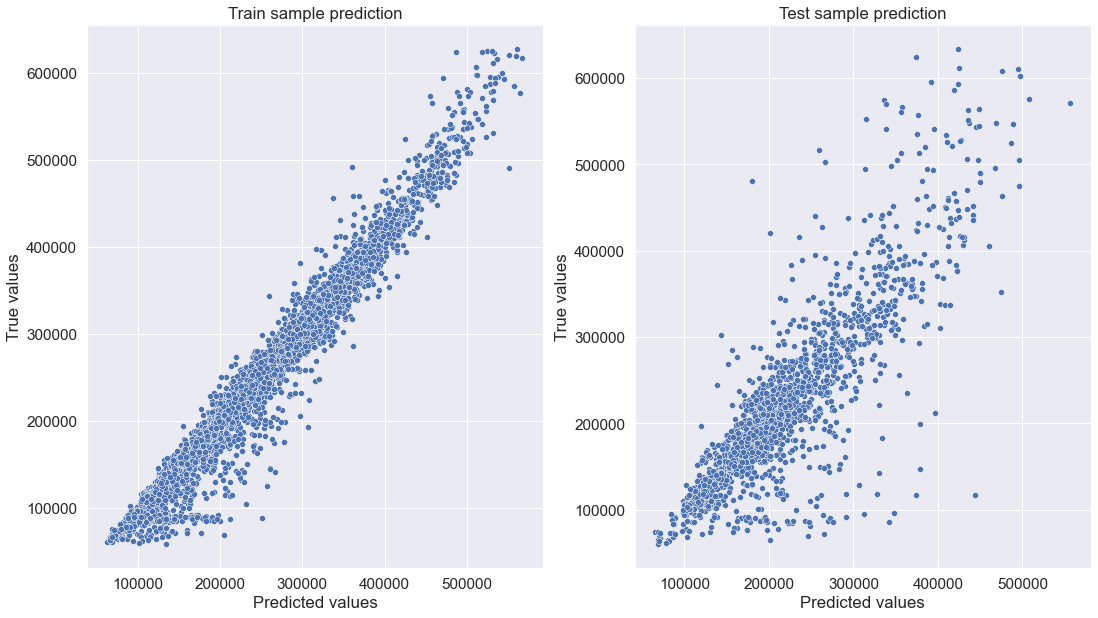

In [133]:
train_pred = forest.predict(x_train)
test_pred = forest.predict(x_test)
evaluate_preds(y_train, train_pred, y_test, test_pred)

In [ ]:
##########################3

### итоговое предсказание

In [134]:
itog_test = test_df[feat]
itog_test = itog_test.fillna(0)
pred = pd.DataFrame(forest.predict(itog_test), columns=['pred'])
pred

,pred
0,156558.641172
1,116777.903242
2,132744.071367
3,169756.661829
4,256429.077852
...,...
4995,181537.934961
4996,404172.398672
4997,146676.931094
4998,187652.454922


### Прогнозирование на тестовом датасете

1. Выполнить для тестового датасета те же этапы обработки и постронияния признаков
2. Не потерять и не перемешать индексы от примеров при построении прогнозов
3. Прогнозы должны быть для все примеров из тестового датасета (для всех строк)

In [135]:
submit = pd.read_csv('sample_submission.csv')
submit.head()

,Id,Price
0,4567,200000.0
1,5925,200000.0
2,960,200000.0
3,3848,200000.0
4,746,200000.0


In [136]:
submit['Price'] = pred
submit.head()

,Id,Price
0,4567,156558.641172
1,5925,116777.903242
2,960,132744.071367
3,3848,169756.661829
4,746,256429.077852


In [137]:
submit.to_csv('submit.csv', index=False)